<a href="https://colab.research.google.com/github/AnhelinaKavaliova/MachineLearning/blob/main/lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Анализ ССЗ

##Подготовка данных

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2024-05-23 20:20:20--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 142.251.2.138, 142.251.2.100, 142.251.2.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G&export=download [following]
--2024-05-23 20:20:20--  https://drive.usercontent.google.com/download?id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2941524 (2.8M) [application/octet-stream]
Saving to: ‘train_case2.csv’

train_case2.csv     100%[===================>]   2.80M  --.-KB/s 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('train_case2.csv', sep = ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'),
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [ ]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
def cross_val(classifier):
  # запустим кросс-валидацию
  cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
  cv_score = np.mean(cv_scores)
  cv_score_std = np.std(cv_scores)
  print(f'CV score is {cv_score}+-{cv_score_std}')

  # обучим пайплайн на всем тренировочном датасете
  classifier.fit(X_train, y_train)
  y_score = classifier.predict_proba(X_test)[:, 1]

In [ ]:
LogReg = Pipeline([
    ('features', feats),
    ('LogReg', LogisticRegression(random_state=42)),
])

cross_val(LogReg)

logreg_pred = LogReg.predict(X_test)
logreg_prob = LogReg.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763


In [ ]:
RandomForest = Pipeline([
    ('features', feats),
    ('RandomForest', RandomForestClassifier(random_state=42)),
])

cross_val(RandomForest)

forest_pred = RandomForest.predict(X_test)
forest_prob = RandomForest.predict_proba(X_test)[:, 1]

CV score is 0.7743796633622809+-0.003611330100912611


In [ ]:
GradientBoosting = Pipeline([
    ('features', feats),
    ('GradientBoosting', GradientBoostingClassifier(random_state=42)),
])

cross_val(GradientBoosting)

gb_pred = GradientBoosting.predict(X_test)
gb_prob = GradientBoosting.predict_proba(X_test)[:, 1]

CV score is 0.8023336401314394+-0.003067762759094604


In [ ]:
def get_metrics(y_true, y_pred, y_prob):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, auc, f1

In [ ]:
logreg_metrics = get_metrics(y_test, logreg_pred, logreg_prob)
forest_metrics = get_metrics(y_test, forest_pred, forest_prob)
gb_metrics = get_metrics(y_test, gb_pred, gb_prob)

In [ ]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

def business_metrics(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cnf_matrix.ravel()

    rubl_1 = (FN + TP) * rubl_late_treatment #расходы, если не делать тест и ждать симптомов
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment #расходы, если делать тест всем и лечить группу большых
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment #расходы, если использовать МЛ

    return rubl_1, rubl_test_all, rubl_ML

In [ ]:
logreg_business_metrics = business_metrics(y_test, logreg_pred)
forest_business_metrics = business_metrics(y_test, forest_pred)
gb_business_metrics = business_metrics(y_test, gb_pred)

##Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score

In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Precision': [logreg_metrics[0], forest_metrics[0], gb_metrics[0]],
    'Recall': [logreg_metrics[1], forest_metrics[1], gb_metrics[1]],
    'AUC': [logreg_metrics[2], forest_metrics[2], gb_metrics[2]],
    'F1 Score': [logreg_metrics[3], forest_metrics[3], gb_metrics[3]]
})

print(metrics_df)

                 Model  Precision    Recall       AUC  F1 Score
0  Logistic Regression   0.745261  0.670392  0.784035  0.705847
1        Random Forest   0.717104  0.695046  0.771037  0.705903
2    Gradient Boosting   0.753097  0.693318  0.802615  0.721972


##Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока

In [ ]:
business_metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'rubl_1': [logreg_business_metrics[0], forest_business_metrics[0], gb_business_metrics[0]],
    'rubl_test_all': [logreg_business_metrics[1], forest_business_metrics[1], gb_business_metrics[1]],
    'rubl_ML': [logreg_business_metrics[2], forest_business_metrics[2], gb_business_metrics[2]],
})

print(business_metrics_df)

                 Model     rubl_1  rubl_test_all    rubl_ML
0  Logistic Regression  173600000      154700000  155436200
1        Random Forest  173600000      154700000  155213200
2    Gradient Boosting  173600000      154700000  154697400


##Вывод

In [ ]:
metrics_df['mean_score'] = metrics_df[['Precision', 'Recall', 'AUC', 'F1 Score']].mean(axis=1)

max_model = metrics_df.loc[metrics_df['mean_score'].idxmax()]

print(metrics_df[['Model', 'mean_score']])

print(f'Model with the max score: {max_model["Model"]}')

                 Model  mean_score
0  Logistic Regression    0.726384
1        Random Forest    0.722273
2    Gradient Boosting    0.742751
Model with the max score: Gradient Boosting


In [ ]:
business_metrics_df['mean_rub'] = business_metrics_df[['rubl_1', 'rubl_test_all', 'rubl_ML']].mean(axis=1)

min_model = business_metrics_df.loc[business_metrics_df['mean_rub'].idxmin()]

print(business_metrics_df[['Model', 'mean_rub']])

print(f'Model with the minimum cost: {min_model["Model"]}')

                 Model      mean_rub
0  Logistic Regression  1.612454e+08
1        Random Forest  1.611711e+08
2    Gradient Boosting  1.609991e+08
Model with the minimum cost: Gradient Boosting


**Лучше всех справилась модель Gradient Boosting**

##Найти порог классификации по деньгам для лучшей модели

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, gb_prob)

In [ ]:
def business_threshold_calibrate(y_test, gb_prob, thresholds, rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    rubl_ML_ = 1_000_000_000
    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():

        cnf_matrix = confusion_matrix(y_test, gb_prob > opt_buisness_tr)
        TN, FP, FN, TP = cnf_matrix.ravel()
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr
            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)

    print('Расходы, если использовать МЛ:', rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0, 1, n), rs)
    plt.show()

    return business_threshold

Расходы, если использовать МЛ: 152333600


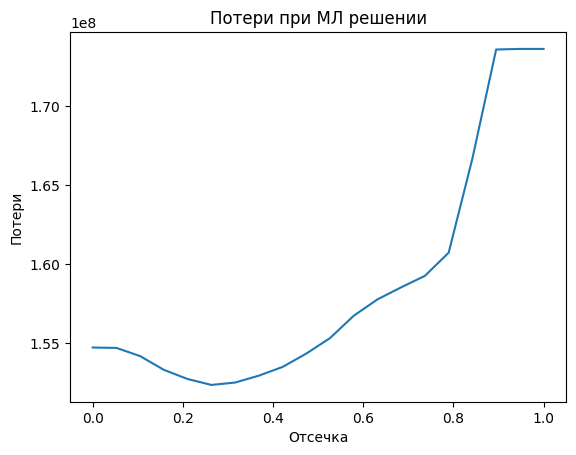

Уровень порога по бизнес метрике: 0.2631578947368421


In [ ]:
busines_tr = business_threshold_calibrate(
    y_test, gb_prob, thresholds,
    rubl_test=1400,
    rubl_early_treatment=15000,
    rubl_late_treatment=20000
)

print('Уровень порога по бизнес метрике:', busines_tr)